In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Function to find Keypoint and match between 2 images

In [2]:
def detect_and_match_keypoint(image_1,image_2):
    # image_1 = query image
    # image_2 = train image
    # Initiate SIFT detector
    sift = cv2.SIFT()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image_1,None)
    kp2, des2 = sift.detectAndCompute(image_2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    # Apply ratio test
    match_details = []
    image_1_keypoint = []
    image_2_keypoint = []
    for m,n in matches:
        if m.distance < 0.2*n.distance:
            match_details.append([m])
            image_1_keypoint.append(kp1[m.queryIdx])
            image_2_keypoint.append(kp2[m.trainIdx])
    return match_details,np.float32([kp.pt for kp in image_1_keypoint]),np.float32([kp.pt for kp in image_2_keypoint])

# Function to draw matching keypoint

In [3]:
def draw_match_keypoint(image_1_keypoint,image_2_keypoint,image_1,image_2):
    image_1_rows,image_1_cols,n_chan = image_1.shape
    image_2_rows,image_2_cols,n_chan = image_2.shape
    match_image_rows = image_1_rows if image_1_rows > image_2_rows else image_2_rows
    match_image_cols = image_1_cols + image_2_cols
    match_image = np.zeros((match_image_rows, match_image_cols,n_chan),dtype="uint8")
    match_image[0:image_1_rows,0:image_1_cols] = image_1
    match_image[0:image_2_rows,image_1_cols:] = image_2
    for i in range(0,len(image_1_keypoint)):
        point_image_1 = (int(image_1_keypoint[i][0]), int(image_1_keypoint[i][1]))
        point_image_2 = (int(image_2_keypoint[i][0]) + image_1_cols, int(image_2_keypoint[i][1]))
        cv2.line(match_image, point_image_1, point_image_2,(200,150,100), 1)
    return match_image

# Function to use RANSAC to find transform matrix 

In [4]:
def merge_image(image_1_keypoint,image_2_keypoint,image_1,image_2):
    #find transform matrix by using RANSAC
    h, status = cv2.findHomography(image_2_keypoint, image_1_keypoint , cv2.RANSAC , 4.0)
    print "H is a transform matrix"
    print h
    #transform coordinate image
    panorama_image = cv2.warpPerspective(image_2, h,(image_2.shape[1] + image_1.shape[1], image_2.shape[0]))
    panorama_image[0:image_1.shape[0], 0:image_1.shape[1]] = image_1
    return h,panorama_image

# Main Function

#### Read image and find its keypoint

In [5]:
image_1 = cv2.imread('../bryce_left_01.png',0)
image_2 = cv2.imread('../bryce_right_01.png',0) # trainImage
match_details,image_1_keypoint,image_2_keypoint = detect_and_match_keypoint(image_1,image_2)

#### Merge two image by using RANSAC

In [6]:
image_1_color = cv2.imread('../bryce_left_01.png',1)
image_2_color = cv2.imread('../bryce_right_01.png',1)
h,panorama_image = merge_image(image_1_keypoint,image_2_keypoint,image_1_color,image_2_color)

H is a transform matrix
[[  6.25541649e-01  -1.39706639e-02   3.37595081e+02]
 [ -1.33550548e-01   8.61236632e-01   5.80944827e+01]
 [ -3.75852154e-04  -7.29235963e-06   1.00000000e+00]]


# Output

#### draw matching keypoint

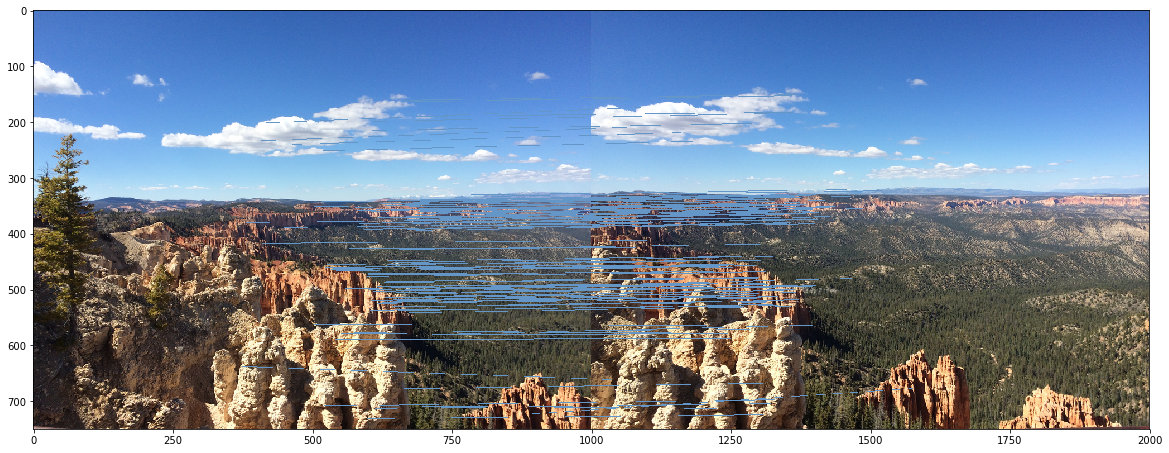

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(draw_match_keypoint(image_1_keypoint,image_2_keypoint,image_1_color,image_2_color), cv2.COLOR_BGR2RGB))
plt.show()

#### draw panorama image

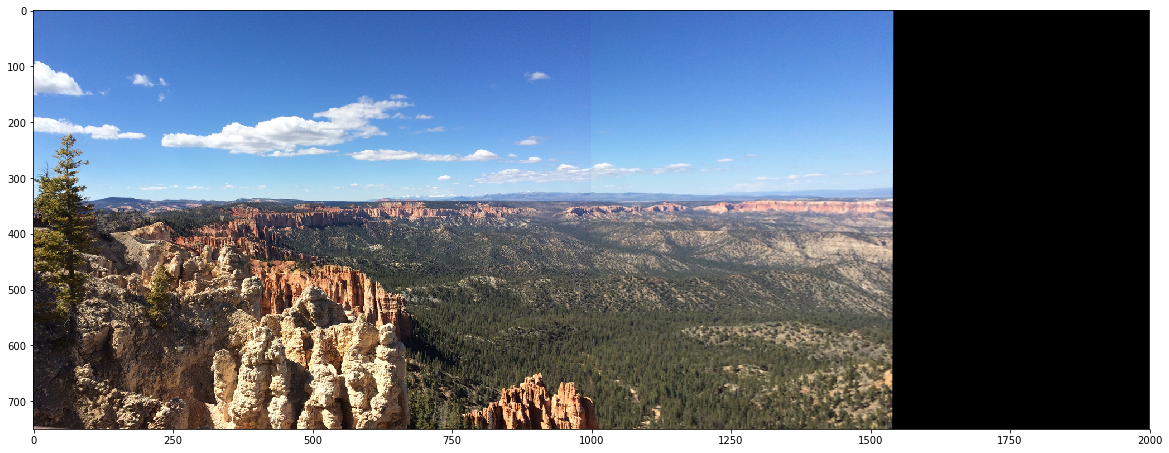

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(panorama_image, cv2.COLOR_BGR2RGB))
plt.show()